In [1]:
import numpy as np
import pandas as pd
from pandas import Series

from bs4 import BeautifulSoup as bts
import requests
from urllib.request import urlopen
from decimal import Decimal

from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
def getAndParseURL(url):
    result = requests.get(url,headers={"User-Agent":"Mozilla/5.0"})
    soup = bts(result.text, 'html.parser')
    return soup

In [3]:
Sayfa_Sayısı = list(range(1,1617,50))
PAGES = []

IMDB_URL_Part1 = "https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=action&sort=user_rating,desc&start="
IMDB_URL_Part2 = "&ref_=adv_nxt"
html = getAndParseURL("https://www.imdb.com/search/title/?genres=action&sort=user_rating,desc&title_type=feature&num_votes=25000,&pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=5aab685f-35eb-40f3-95f7-c53f09d542c3&pf_rd_r=BSQ0CNKW0HDSGXPKSMPX&pf_rd_s=right-6&pf_rd_t=15506&pf_rd_i=top&ref_=chttp_gnr_1")

for sayfa in Sayfa_Sayısı:    
    PAGES.append(IMDB_URL_Part1+str(sayfa)+IMDB_URL_Part2)
    
for p in PAGES:
    print (p)

https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=action&sort=user_rating,desc&start=1&ref_=adv_nxt
https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=action&sort=user_rating,desc&start=51&ref_=adv_nxt
https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=action&sort=user_rating,desc&start=101&ref_=adv_nxt
https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=action&sort=user_rating,desc&start=151&ref_=adv_nxt
https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=action&sort=user_rating,desc&start=201&ref_=adv_nxt
https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=action&sort=user_rating,desc&start=251&ref_=adv_nxt
https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=action&sort=user_rating,desc&start=301&ref_=adv_nxt
https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=action&sort=use

In [4]:
ALL_MOVIES = []

for page in PAGES[::]:
    html = getAndParseURL(page)    
    for div in html.findAll("div", {"class": "lister-item-content"}):
        for h3 in div.findAll("h3", {"class": "lister-item-header"}):
            for a in h3.findAll("a"):
                ALL_MOVIES.append("https://www.imdb.com"+a["href"])
                #print (a["href"])  

In [5]:
ALL_MOVIES[:3]

['https://www.imdb.com/title/tt10698680/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt0468569/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt0167260/?ref_=adv_li_tt']

In [6]:
len(ALL_MOVIES)

1621

Sonraki 6 hücreyi çalıştırmadan csv'den çekme aşamasına geçebiliriz.

In [ ]:
FEATURES = []

for m in ALL_MOVIES[:501]:
    movie = getAndParseURL(m)
    film_name = movie.find ("h1", {"data-testid": "hero-title-block__title"}).text
    """for div in movie.findAll("div",{"class","sc-94726ce4-1 iNShGo"}):
        #film_name = div.find ("h1", {"data-testid": "hero-title-block__title"})
        film_name = div.h1.text
    """
      
    
    imdb_rating = movie.find ('span', {'class':'sc-7ab21ed2-1'}).text
    director = movie.find ("a", {"class":"ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link"}).text
    release_date = movie.find ("a", {"class":"ipc-link ipc-link--baseAlt ipc-link--inherit-color sc-8c396aa2-1 WIUyh"}).text
    runtime = movie.find ("li", {"data-testid":"title-techspec_runtime"}).text.replace("Runtime","").replace("hours", "h").replace("minutes","m")
    
    
    for div in movie.findAll("div", {"data-testid":"title-boxoffice-section"}):
        #Budget
        for li in div.findAll("li",{"data-testid":"title-boxoffice-budget"}):
            for span in li.findAll("span",{"class":"ipc-metadata-list-item__list-content-item"}) :
                budget = span.text
        #Gross
        for li2 in div.findAll("li",{"role":"presentation"}):
            for span2 in li2.findAll("span",{"class":"ipc-metadata-list-item__list-content-item"}) :
                gross = span2.text

    all_reviews = []
    for ul in movie.findAll("ul", {"data-testid":"reviewContent-all-reviews"}):
        for span in ul.findAll("span", {"class":"score"}):
            #print (span.text)
            all_reviews.append(span.text)
            
    user_reviews = all_reviews[0]
    critic_reviews = all_reviews[1]
    try:
        metascore = all_reviews[2]
    except IndexError :
        metascore = 0          
    
    #stars
    all_stars = []
    for ul in movie.findAll("ul", {"class":"ipc-inline-list ipc-inline-list--show-dividers ipc-inline-list--inline ipc-metadata-list-item__list-content baseAlt"}):
        for a in ul.findAll("a", {"rel href":"/title/tt0468569/fullcredits/cast?ref_=tt_ov_st_sm"} ):
            star = a.text
            all_stars.append(a.text)
    

    FEATURES.append([film_name,imdb_rating,director,release_date,runtime,budget,gross,user_reviews,critic_reviews,metascore])
    
feature_columns= ["FILM", "IMDB RATING", "DIRECTOR", "RELEASE DATE", "RUN TIME","BUDGET","GROSS","USER REVIEWS","CRITIC REVIEWS","METASCORE"]
df1 = pd.DataFrame.from_records(FEATURES, columns=feature_columns)

In [ ]:
FEATURES = []

for m in ALL_MOVIES[501:]:
    movie = getAndParseURL(m)
    film_name = movie.find ("h1", {"data-testid": "hero-title-block__title"}).text
    """for div in movie.findAll("div",{"class","sc-94726ce4-1 iNShGo"}):
        #film_name = div.find ("h1", {"data-testid": "hero-title-block__title"})
        film_name = div.h1.text
    """
      
    
    imdb_rating = movie.find ('span', {'class':'sc-7ab21ed2-1'}).text
    director = movie.find ("a", {"class":"ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link"}).text
    release_date = movie.find ("a", {"class":"ipc-link ipc-link--baseAlt ipc-link--inherit-color sc-8c396aa2-1 WIUyh"}).text
    runtime = movie.find ("li", {"data-testid":"title-techspec_runtime"}).text.replace("Runtime","").replace("hours", "h").replace("minutes","m")
    
    
    for div in movie.findAll("div", {"data-testid":"title-boxoffice-section"}):
        #Budget
        for li in div.findAll("li",{"data-testid":"title-boxoffice-budget"}):
            for span in li.findAll("span",{"class":"ipc-metadata-list-item__list-content-item"}) :
                budget = span.text
        #Gross
        for li2 in div.findAll("li",{"role":"presentation"}):
            for span2 in li2.findAll("span",{"class":"ipc-metadata-list-item__list-content-item"}) :
                gross = span2.text

    all_reviews = []
    for ul in movie.findAll("ul", {"data-testid":"reviewContent-all-reviews"}):
        for span in ul.findAll("span", {"class":"score"}):
            #print (span.text)
            all_reviews.append(span.text)
            
    user_reviews = all_reviews[0]
    critic_reviews = all_reviews[1]
    try:
        metascore = all_reviews[2]
    except IndexError :
        metascore = 0          
    
    #stars
    all_stars = []
    for ul in movie.findAll("ul", {"class":"ipc-inline-list ipc-inline-list--show-dividers ipc-inline-list--inline ipc-metadata-list-item__list-content baseAlt"}):
        for a in ul.findAll("a", {"rel href":"/title/tt0468569/fullcredits/cast?ref_=tt_ov_st_sm"} ):
            star = a.text
            all_stars.append(a.text)
    

    FEATURES.append([film_name,imdb_rating,director,release_date,runtime,budget,gross,user_reviews,critic_reviews,metascore])
    
feature_columns= ["FILM", "IMDB RATING", "DIRECTOR", "RELEASE DATE", "RUN TIME","BUDGET","GROSS","USER REVIEWS","CRITIC REVIEWS","METASCORE"]
df2 = pd.DataFrame.from_records(FEATURES, columns=feature_columns)

In [ ]:
df1.shape

In [ ]:
df2.shape

In [ ]:
df1.to_csv('ALL_MOVIES',sep=',',header=True,index=False)

In [ ]:
df2.to_csv('ALL_MOVIES2',sep=',',header=True,index=False)

Yukardaki bloklarda df1 ve df2 olarak çekilen film bilgileri hızlı olması açısından csv'ye atıldıktan sonra csv'den okunarak birleştirildi.

In [7]:
df1 = pd.read_csv('ALL_MOVIES', index_col=None)
df2 = pd.read_csv('ALL_MOVIES2', index_col=None)
df = pd.concat([df1,df2])

Index belirlediğimiz dizi olarak atandı.

In [8]:
index = np.arange(1,1622)

In [9]:
df.set_index(index,inplace=True)

In [10]:
df.head()

,FILM,IMDB RATING,DIRECTOR,RELEASE DATE,RUN TIME,BUDGET,GROSS,USER REVIEWS,CRITIC REVIEWS,METASCORE
1,K.G.F: Chapter 2,9.6,Prashanth Neel,2022,2 h 48 m,"₹800,000,000 (estimated)","$2,874,000",1.1K,23,0
2,The Dark Knight,9.0,Christopher Nolan,2008,2 h 32 m,"$185,000,000 (estimated)","$1,006,102,277",8K,434,84
3,The Lord of the Rings: The Return of the King,9.0,Peter Jackson,2003,3 h 21 m,"$94,000,000 (estimated)","$1,146,436,214",4K,340,94
4,RRR (Rise Roar Revolt),8.9,S.S. Rajamouli,2022,3 h 7 m,"₹3,500,000,000 (estimated)","$99,592,871",996,33,87
5,Inception,8.8,Christopher Nolan,2010,2 h 28 m,"$160,000,000 (estimated)","$836,848,102",4.5K,480,74


In [11]:
df.tail()

,FILM,IMDB RATING,DIRECTOR,RELEASE DATE,RUN TIME,BUDGET,GROSS,USER REVIEWS,CRITIC REVIEWS,METASCORE
1617,Gunday,2.3,Ali Abbas Zafar,2014,2 h 32 m,"$20,000,000 (estimated)","$11,061,813",896,21,0
1618,Radhe,2.3,Prabhu Deva,2021,2 h 15 m,"$20,000,000 (estimated)","$1,900,312",2.5K,22,0
1619,Race 3,2.1,Remo D'Souza,2018,2 h 40 m,"$20,000,000 (estimated)","$29,969,693",472,24,0
1620,House of the Dead,2.1,Uwe Boll,2003,1 hour 30 m,"$12,000,000 (estimated)","$13,818,181",606,138,15
1621,Sadak 2,1.1,Mahesh Bhatt,2020,2 h 13 m,"$12,000,000 (estimated)","$2,073",728,22,0


In [12]:
df.shape

(1621, 10)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1621 entries, 1 to 1621
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FILM            1621 non-null   object 
 1   IMDB RATING     1621 non-null   float64
 2   DIRECTOR        1621 non-null   object 
 3   RELEASE DATE    1621 non-null   int64  
 4   RUN TIME        1621 non-null   object 
 5   BUDGET          1621 non-null   object 
 6   GROSS           1621 non-null   object 
 7   USER REVIEWS    1621 non-null   object 
 8   CRITIC REVIEWS  1621 non-null   int64  
 9   METASCORE       1621 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 139.3+ KB


In [14]:
df.columns

Index(['FILM', 'IMDB RATING', 'DIRECTOR', 'RELEASE DATE', 'RUN TIME', 'BUDGET',
       'GROSS', 'USER REVIEWS', 'CRITIC REVIEWS', 'METASCORE'],
      dtype='object')

## DATA CONVERT

In [15]:
df["IMDB RATING"] = df["IMDB RATING"].astype(float)

In [16]:
df["RELEASE DATE"] = df["RELEASE DATE"].astype(int)
df["METASCORE"] = df["METASCORE"].astype(int)
df["CRITIC REVIEWS"] = df["CRITIC REVIEWS"].astype(int)

In [17]:
df[["a", "a1"]] = df[df["USER REVIEWS"].str.contains("K")]["USER REVIEWS"].str.split("K", expand = True)
df["a"] = df["a"].apply(lambda x: float(x) * 1000)

In [18]:
df.loc[df.a.isna(), 'a'] = df[~df["USER REVIEWS"].str.contains("K")]["USER REVIEWS"]

In [19]:
df["a"]

1       1100.0
2       8000.0
3       4000.0
4          996
5       4500.0
         ...  
1617       896
1618    2500.0
1619       472
1620       606
1621       728
Name: a, Length: 1621, dtype: object

In [20]:
df.drop(["USER REVIEWS", "a1"], axis=1, inplace=True)

In [21]:

df = df.rename(columns={'a':"USER REVIEWS"})
df["USER REVIEWS"] = df["USER REVIEWS"].astype(float)

In [22]:
df["BUDGET"] = df["BUDGET"].str.replace(",", "").str.extract('(\d+)')
df["BUDGET"] = [float(i) for i in df["BUDGET"]]

In [23]:
df["GROSS"] = df["GROSS"].str.replace(",", "").str.extract('(\d+)')
df["GROSS"] = df["GROSS"].astype(float)

In [24]:
df["RUN TIME"] = df["RUN TIME"].str.replace("h", "").str.replace("m","")

In [25]:
df2 = df["RUN TIME"].str.split(' ', expand=True)

In [26]:
df["RUN TIME"] = df2[0].astype(float) * 60 + df2[2].astype(float)

Veri dönüştürmesinden sonra datada boş veya Nan değer var mı kontrol edildi.

In [27]:
df.isnull().any()

FILM              False
IMDB RATING       False
DIRECTOR          False
RELEASE DATE      False
RUN TIME           True
BUDGET            False
GROSS             False
CRITIC REVIEWS    False
METASCORE         False
USER REVIEWS      False
dtype: bool

RUN TIME kolonunda düzenlemeye ihtiyacımız var.

Eksik veri satırları ve sayısı kontrol edildi.

In [28]:
df[df['RUN TIME'].isnull() == True]

,FILM,IMDB RATING,DIRECTOR,RELEASE DATE,RUN TIME,BUDGET,GROSS,CRITIC REVIEWS,METASCORE,USER REVIEWS
26,Oldeuboi,8.4,Park Chan-wook,2003,NaN,3.000000e+06,15194593.0,335,77,1100.0
55,Sherlock Jr.,8.2,Buster Keaton,1924,NaN,7.500000e+05,977375.0,78,0,344.0
64,Mad Max: Fury Road,8.1,George Miller,2015,NaN,1.500000e+08,375709470.0,833,90,2200.0
110,Ying xiong,7.9,Yimou Zhang,2002,NaN,3.100000e+07,177395557.0,158,85,893.0
113,Wo hu cang long,7.9,Ang Lee,2000,NaN,1.700000e+07,213525736.0,282,94,1700.0
248,Collateral,7.5,Michael Mann,2004,NaN,6.500000e+07,220239925.0,229,71,982.0
304,Okja,7.3,Bong Joon Ho,2017,NaN,5.000000e+07,2049823.0,285,75,380.0
351,Anthropoid,7.2,Sean Ellis,2016,NaN,1.200000e+08,5079219.0,235,59,158.0
430,Gwoemul,7.1,Bong Joon Ho,2006,NaN,1.221550e+10,89433436.0,395,85,380.0
444,Blade,7.1,Stephen Norrington,1998,NaN,4.500000e+07,131211377.0,182,47,699.0


In [29]:
len(df[df['RUN TIME'].isnull() == True])

30

Nan gelen değerler aslında verinin saat ve dakika kısmının ayrılması aşamasında gerçekte boş değilken None geldiği için 120 dk  (çoğunluğu 2 saat olarak geliyor. ) olarak atandı.

In [30]:
df2[df2[2].isnull() == True]

,0,1,2,3
26,2,,None,None
55,45,,None,None
64,2,,None,None
110,2,,None,None
113,2,,None,None
248,2,,None,None
304,2,,None,None
351,2,,None,None
430,2,,None,None
444,2,,None,None


In [31]:
df["RUN TIME"].fillna(120,inplace=True)

Önceden RUN TIME bilgisi Nan gelen  " Oldeuboi	" filmi kontrol edildi.

In [32]:
df.loc[26:"runtime"]

,FILM,IMDB RATING,DIRECTOR,RELEASE DATE,RUN TIME,BUDGET,GROSS,CRITIC REVIEWS,METASCORE,USER REVIEWS
26,Oldeuboi,8.4,Park Chan-wook,2003,120.0,3.000000e+06,15194593.0,335,77,1100.0
27,Mononoke-hime,8.4,Hayao Miyazaki,1997,134.0,2.400000e+09,169785704.0,128,76,779.0
28,Aliens,8.4,James Cameron,1986,137.0,1.850000e+07,131060248.0,220,84,1400.0
29,Raiders of the Lost Ark,8.4,Steven Spielberg,1981,115.0,1.800000e+07,389925971.0,273,85,1000.0
30,1917,8.3,Sam Mendes,2019,119.0,9.500000e+07,384919389.0,515,78,3300.0
...,...,...,...,...,...,...,...,...,...,...
1617,Gunday,2.3,Ali Abbas Zafar,2014,152.0,2.000000e+07,11061813.0,21,0,896.0
1618,Radhe,2.3,Prabhu Deva,2021,135.0,2.000000e+07,1900312.0,22,0,2500.0
1619,Race 3,2.1,Remo D'Souza,2018,160.0,2.000000e+07,29969693.0,24,0,472.0
1620,House of the Dead,2.1,Uwe Boll,2003,90.0,1.200000e+07,13818181.0,138,15,606.0


In [33]:
df.isnull().any()

FILM              False
IMDB RATING       False
DIRECTOR          False
RELEASE DATE      False
RUN TIME          False
BUDGET            False
GROSS             False
CRITIC REVIEWS    False
METASCORE         False
USER REVIEWS      False
dtype: bool

Data son hali gözden geçirildi.

In [34]:
df.head(10)

,FILM,IMDB RATING,DIRECTOR,RELEASE DATE,RUN TIME,BUDGET,GROSS,CRITIC REVIEWS,METASCORE,USER REVIEWS
1,K.G.F: Chapter 2,9.6,Prashanth Neel,2022,168.0,8.000000e+08,2.874000e+06,23,0,1100.0
2,The Dark Knight,9.0,Christopher Nolan,2008,152.0,1.850000e+08,1.006102e+09,434,84,8000.0
3,The Lord of the Rings: The Return of the King,9.0,Peter Jackson,2003,201.0,9.400000e+07,1.146436e+09,340,94,4000.0
4,RRR (Rise Roar Revolt),8.9,S.S. Rajamouli,2022,187.0,3.500000e+09,9.959287e+07,33,87,996.0
5,Inception,8.8,Christopher Nolan,2010,148.0,1.600000e+08,8.368481e+08,480,74,4500.0
6,The Lord of the Rings: The Two Towers,8.8,Peter Jackson,2002,179.0,9.400000e+07,9.478962e+08,314,87,2600.0
7,The Lord of the Rings: The Fellowship of the Ring,8.8,Peter Jackson,2001,178.0,9.300000e+07,8.980947e+08,213,92,5600.0
8,Dag II,8.7,Alper Caglar,2016,135.0,2.000000e+06,1.137890e+07,3,0,154.0
9,Shershaah,8.7,Vishnuvardhan,2021,135.0,2.000000e+06,1.137890e+07,25,0,3100.0
10,The Matrix,8.7,Lana Wachowski,1999,136.0,6.300000e+07,4.672227e+08,250,73,4800.0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1621 entries, 1 to 1621
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FILM            1621 non-null   object 
 1   IMDB RATING     1621 non-null   float64
 2   DIRECTOR        1621 non-null   object 
 3   RELEASE DATE    1621 non-null   int32  
 4   RUN TIME        1621 non-null   float64
 5   BUDGET          1621 non-null   float64
 6   GROSS           1621 non-null   float64
 7   CRITIC REVIEWS  1621 non-null   int32  
 8   METASCORE       1621 non-null   int32  
 9   USER REVIEWS    1621 non-null   float64
dtypes: float64(5), int32(3), object(2)
memory usage: 184.8+ KB


In [36]:
df.describe()

,IMDB RATING,RELEASE DATE,RUN TIME,BUDGET,GROSS,CRITIC REVIEWS,METASCORE,USER REVIEWS
count,1621.000000,1621.000000,1621.000000,1.621000e+03,1.621000e+03,1621.000000,1621.000000,1621.000000
mean,6.494263,2005.216533,114.563849,1.087976e+08,1.674738e+08,198.089451,48.359655,650.188155
std,0.978566,13.044298,21.375835,5.867143e+08,2.576842e+08,143.588657,21.998924,869.419358
min,1.100000,1924.000000,67.000000,1.800000e+01,1.073000e+03,1.000000,0.000000,22.000000
25%,5.900000,1999.000000,100.000000,2.100000e+07,2.216561e+07,93.000000,37.000000,209.000000
50%,6.500000,2008.000000,111.000000,4.500000e+07,7.418968e+07,158.000000,51.000000,377.000000
75%,7.200000,2015.000000,125.000000,9.500000e+07,2.005126e+08,268.000000,64.000000,756.000000
max,9.600000,2022.000000,321.000000,1.221550e+10,2.847380e+09,909.000000,98.000000,9400.000000


In [37]:
df.corr()

,IMDB RATING,RELEASE DATE,RUN TIME,BUDGET,GROSS,CRITIC REVIEWS,METASCORE,USER REVIEWS
IMDB RATING,1.000000,-0.136274,0.370431,0.088888,0.227427,0.230095,0.433945,0.193419
RELEASE DATE,-0.136274,1.000000,0.081686,0.052713,0.177976,0.381114,-0.105880,0.253604
RUN TIME,0.370431,0.081686,1.000000,0.131648,0.306550,0.149693,0.088588,0.359214
BUDGET,0.088888,0.052713,0.131648,1.000000,0.036272,0.040247,0.004953,0.037347
GROSS,0.227427,0.177976,0.306550,0.036272,1.000000,0.601468,0.276744,0.582801
CRITIC REVIEWS,0.230095,0.381114,0.149693,0.040247,0.601468,1.000000,0.428664,0.494120
METASCORE,0.433945,-0.105880,0.088588,0.004953,0.276744,0.428664,1.000000,0.213930
USER REVIEWS,0.193419,0.253604,0.359214,0.037347,0.582801,0.494120,0.213930,1.000000


In [38]:
df_numeric_part = df.drop(["FILM", "DIRECTOR"], axis=1)

In [39]:
df_numeric_part.head()

,IMDB RATING,RELEASE DATE,RUN TIME,BUDGET,GROSS,CRITIC REVIEWS,METASCORE,USER REVIEWS
1,9.6,2022,168.0,8.000000e+08,2.874000e+06,23,0,1100.0
2,9.0,2008,152.0,1.850000e+08,1.006102e+09,434,84,8000.0
3,9.0,2003,201.0,9.400000e+07,1.146436e+09,340,94,4000.0
4,8.9,2022,187.0,3.500000e+09,9.959287e+07,33,87,996.0
5,8.8,2010,148.0,1.600000e+08,8.368481e+08,480,74,4500.0


In [40]:
df_string_part  = df[["FILM", "DIRECTOR"]]

In [41]:
df_string_part.head()

,FILM,DIRECTOR
1,K.G.F: Chapter 2,Prashanth Neel
2,The Dark Knight,Christopher Nolan
3,The Lord of the Rings: The Return of the King,Peter Jackson
4,RRR (Rise Roar Revolt),S.S. Rajamouli
5,Inception,Christopher Nolan


## Exploratory Data Analysis; EDA

Datamızı daha iyi inceleyebilmek için numeric_part ve string_part olarak ikiye ayırdık.

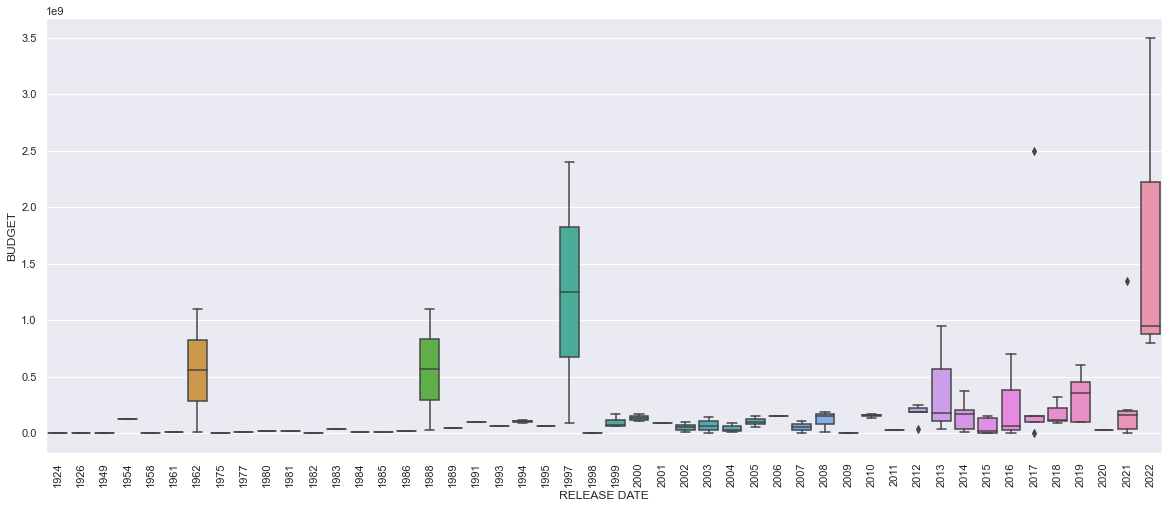

In [55]:
sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot(data=df_numeric_part.iloc[:100,:],x='RELEASE DATE', y='BUDGET')
plt.xticks(rotation = 90)
plt.show()

Yıllara göre filmler için kullanılan bütçeler.

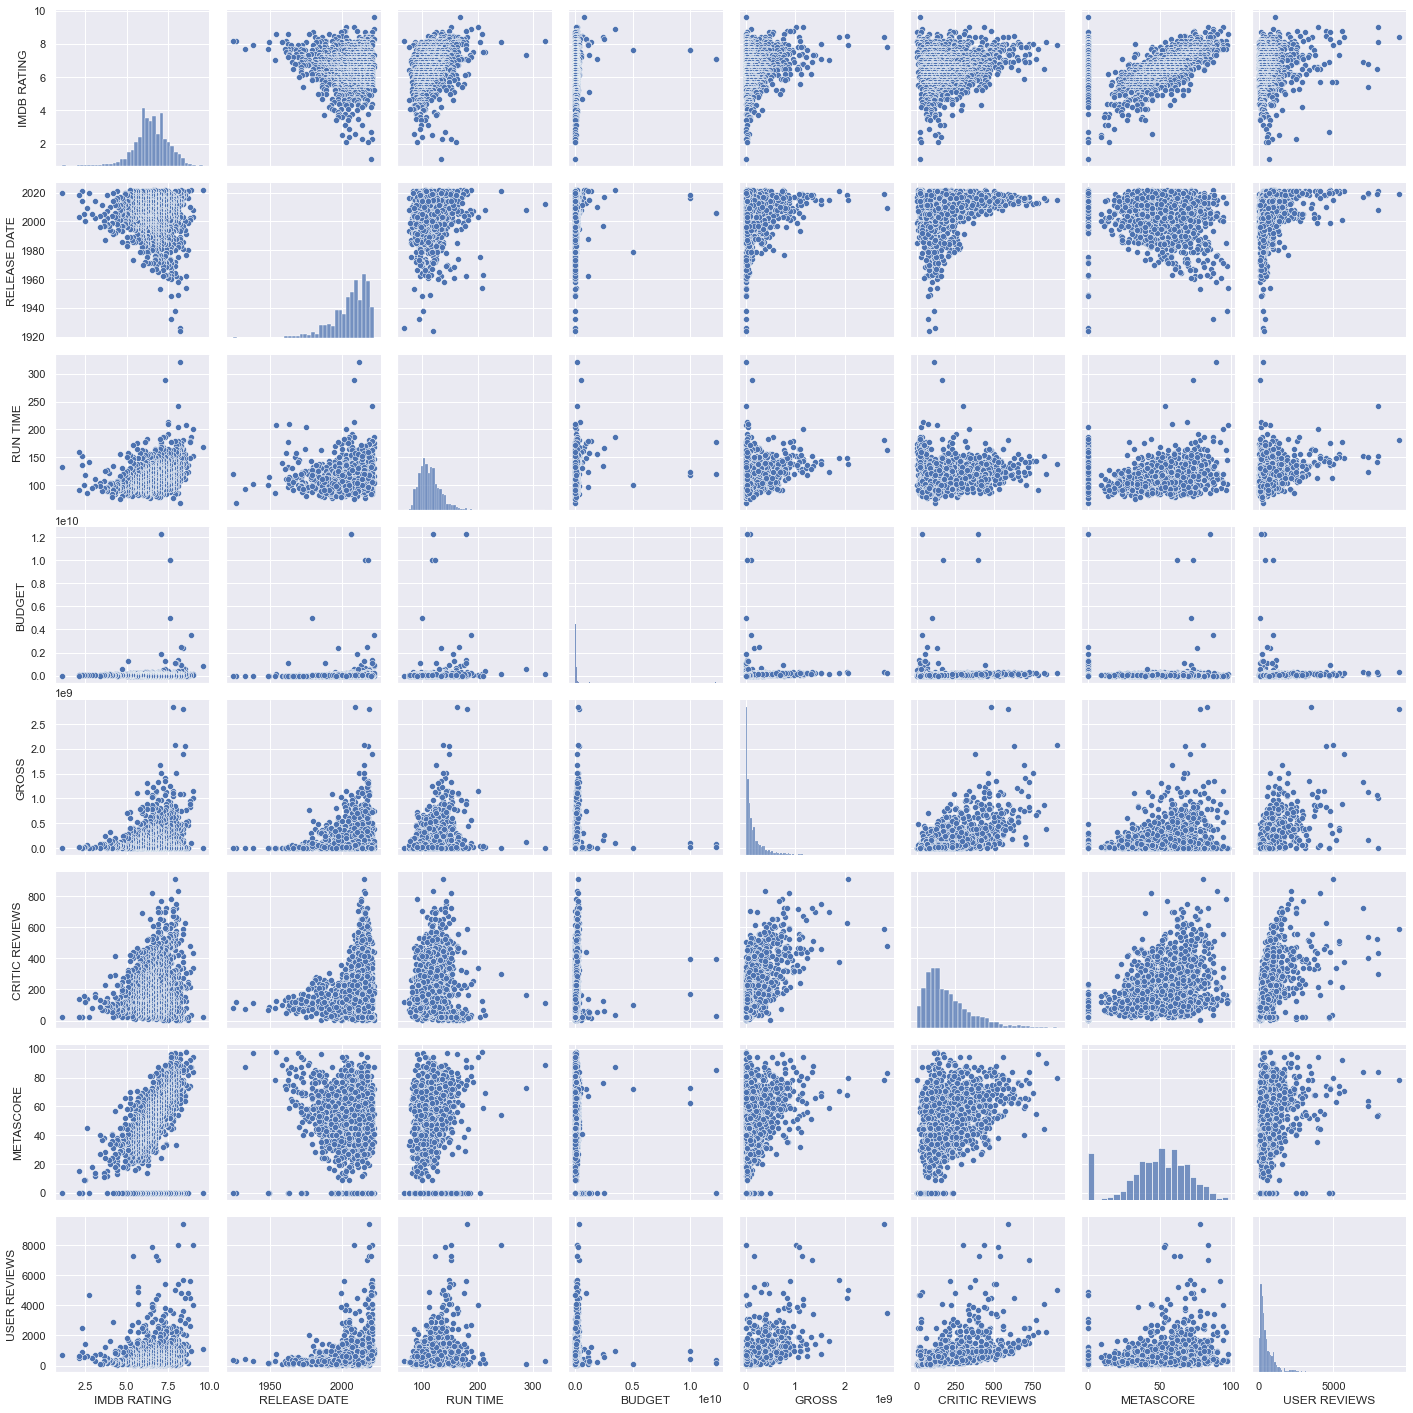

In [56]:
sns.pairplot(data=df_numeric_part, vars=["IMDB RATING", "RELEASE DATE", "RUN TIME",
                                         "BUDGET", "GROSS","CRITIC REVIEWS","METASCORE","USER REVIEWS"])
plt.show()

Değişkenlerimizin birbirleri arasındaki ilişkilerinin gösterimleri.

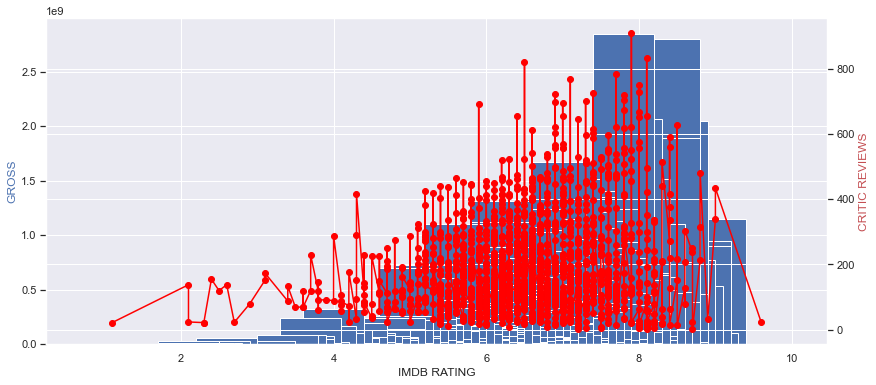

In [57]:
sns.set(style="darkgrid")
fig, ax1 = plt.subplots(figsize = (14,6))

ax2 = ax1.twinx()
ax1.bar(df_numeric_part['IMDB RATING'],df_numeric_part['GROSS'])
ax2.plot(df_numeric_part['IMDB RATING'],df_numeric_part['CRITIC REVIEWS'], 'o-', color="red" )
ax1.set_xlabel('IMDB RATING')
ax1.set_ylabel('GROSS', color='b')
ax2.set_ylabel('CRITIC REVIEWS', color='r')
plt.show()

IMDB puanları, brüt kazanç ve kritik oy sayısı arasındaki ilişkiler.

In [58]:
top_director= df.groupby('DIRECTOR')['GROSS'].sum().reset_index()
top_director.sort_values('GROSS',ascending =False)[0:5]

,DIRECTOR,GROSS
53,Anthony Russo,6.713620e+09
534,Michael Bay,6.601693e+09
775,Steven Spielberg,6.026108e+09
319,J.J. Abrams,4.655292e+09
133,Christopher Nolan,4.188497e+09


In [59]:
filmsBydirector= df.groupby(['DIRECTOR'])['DIRECTOR'].count().sort_values(ascending = False)

In [60]:
filmsBydirector.head()

DIRECTOR
Michael Bay         14
Steven Spielberg    13
Tony Scott          13
Robert Rodriguez    13
Roland Emmerich     12
Name: DIRECTOR, dtype: int64

In [61]:
a = pd.DataFrame(filmsBydirector.iloc[:6])

In [62]:
a

,DIRECTOR
DIRECTOR,
Michael Bay,14
Steven Spielberg,13
Tony Scott,13
Robert Rodriguez,13
Roland Emmerich,12
Antoine Fuqua,12


In [63]:
a.rename(columns={'DIRECTOR': 'FilmSayi'},inplace=True)

In [64]:
a = a.reset_index()


In [65]:
a

,DIRECTOR,FilmSayi
0,Michael Bay,14
1,Steven Spielberg,13
2,Tony Scott,13
3,Robert Rodriguez,13
4,Roland Emmerich,12
5,Antoine Fuqua,12


In [66]:
x= a["DIRECTOR"]

In [67]:
y= a["FilmSayi"]

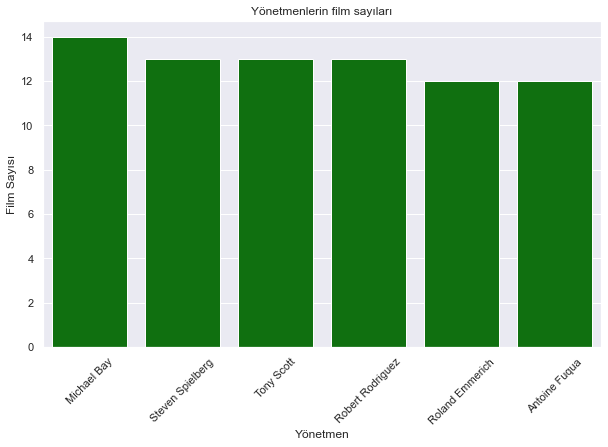

In [69]:
sns.set(rc={'figure.figsize':(10,6)})
fig = sns.barplot(x = x, y = y, 
                  data = a, 
                  color = 'green')
plt.xticks(rotation = 45)
plt.ylabel('Film Sayısı')
plt.xlabel('Yönetmen')
plt.title("Yönetmenlerin film sayıları")
plt.show(fig)

Yönetmenlerin toplam brüt kazanca göre sıralaması.

In [70]:
top_director = pd.pivot_table(df,index=['DIRECTOR'],
                           values=['IMDB RATING','GROSS','METASCORE','USER REVIEWS','RUN TIME'],
                           aggfunc={'GROSS':np.sum,'METASCORE':np.mean,
                                    'USER REVIEWS':np.sum,'IMDB RATING':np.mean,'RUN TIME':np.mean})

In [71]:
director = top_director.sort_values(by='GROSS',
                              ascending = False).reset_index()[0:20]
director

,DIRECTOR,GROSS,IMDB RATING,METASCORE,RUN TIME,USER REVIEWS
0,Anthony Russo,6.713620e+09,8.125000,72.750000,153.250000,16400.0
1,Michael Bay,6.601693e+09,6.442857,43.142857,145.642857,15330.0
2,Steven Spielberg,6.026108e+09,7.261538,66.461538,128.769231,15303.0
3,J.J. Abrams,4.655292e+09,7.316667,70.833333,129.333333,17734.0
4,Christopher Nolan,4.188497e+09,8.250000,78.166667,143.333333,27100.0
5,Roland Emmerich,4.023955e+09,6.108333,44.416667,131.416667,10446.0
6,James Cameron,3.956575e+09,8.040000,77.800000,136.800000,7747.0
7,Jon Watts,3.904321e+09,7.733333,71.000000,136.666667,9500.0
8,Peter Jackson,3.549334e+09,8.450000,88.500000,186.250000,14900.0
9,George Lucas,3.324651e+09,7.325000,65.750000,134.750000,13300.0


Verimizi yönetmenlere göre gruplayıp; toplam kazanç, ortalama IMDB puanı, ortalama meta score, 
ortalama film süresi ve toplam oy sayısıma göre sıraladık.

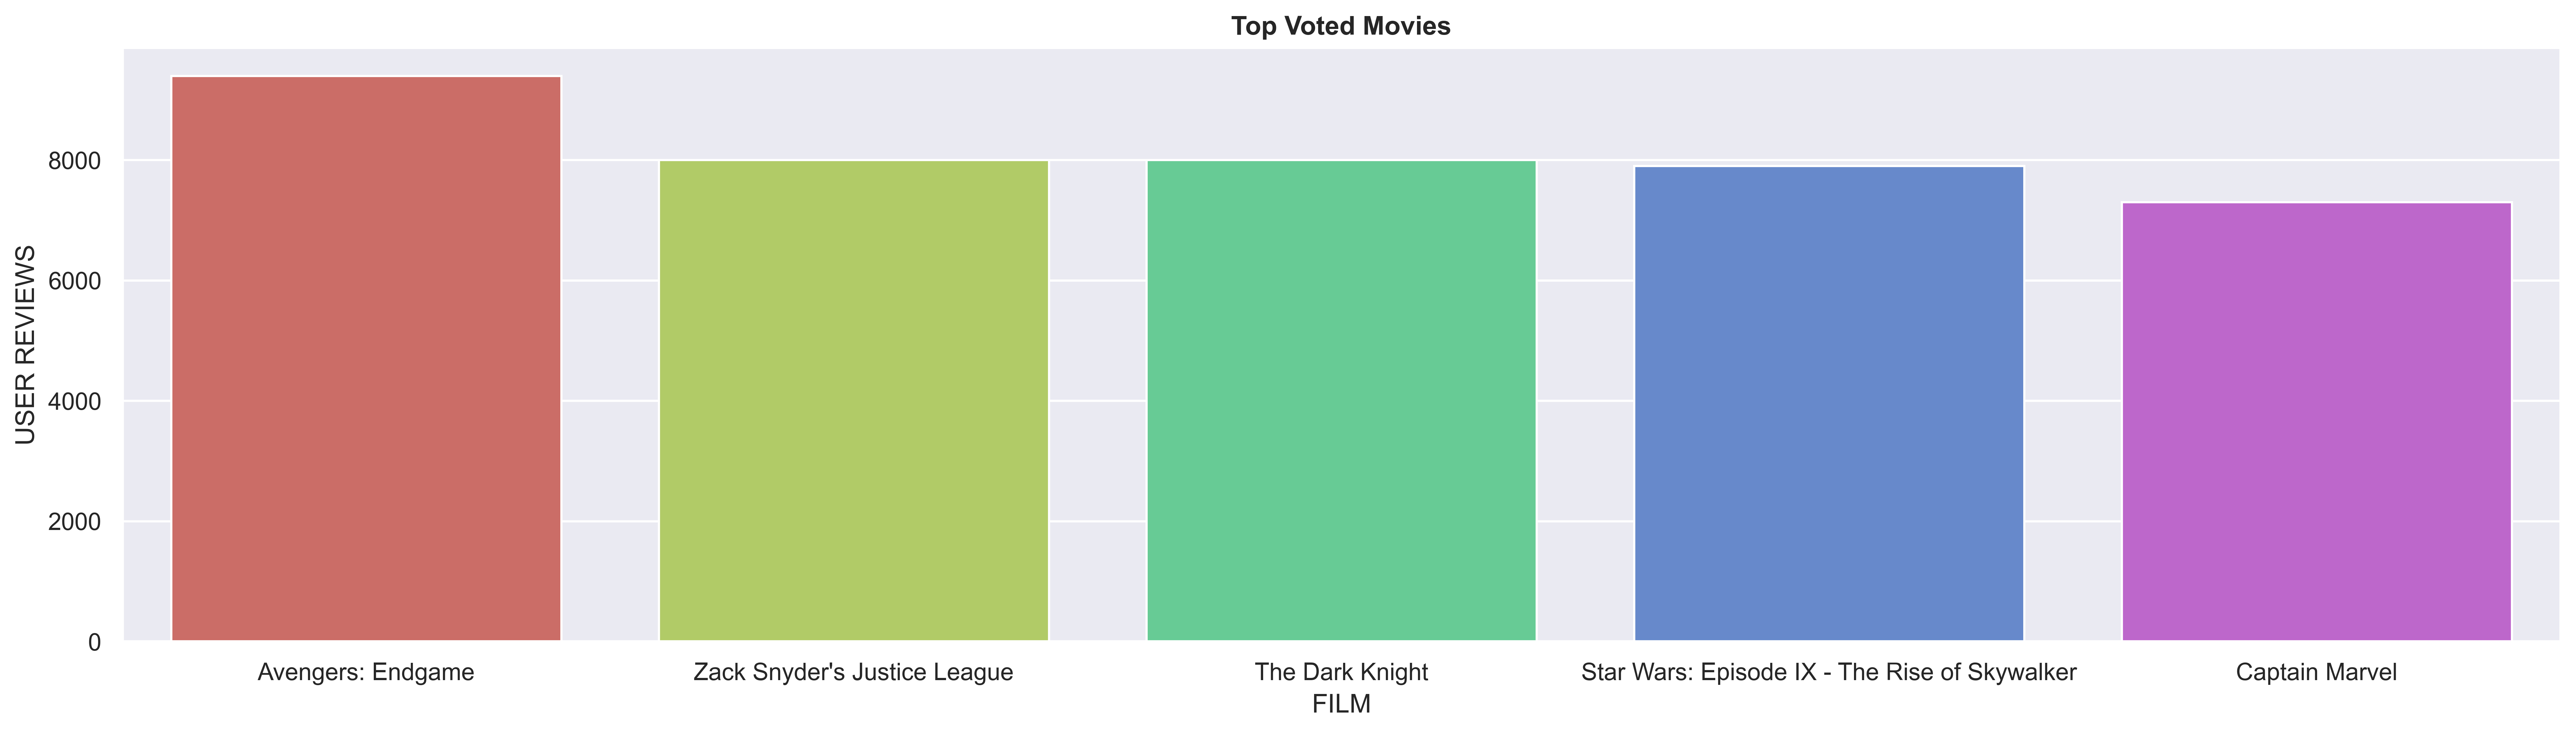

In [74]:
top_voted = df.sort_values(['USER REVIEWS'], ascending = False)

fig,axs=plt.subplots(figsize=(20,5),dpi=500)
g=sns.barplot(x=top_voted['FILM'][:5],y=top_voted['USER REVIEWS'][:5], palette = 'hls')
g.set_title("Top Voted Movies", weight = "bold")
plt.show()

En çok oy kullanılan filmler.

<AxesSubplot:title={'center':'FILM INFORMATION HEAT MAP'}>

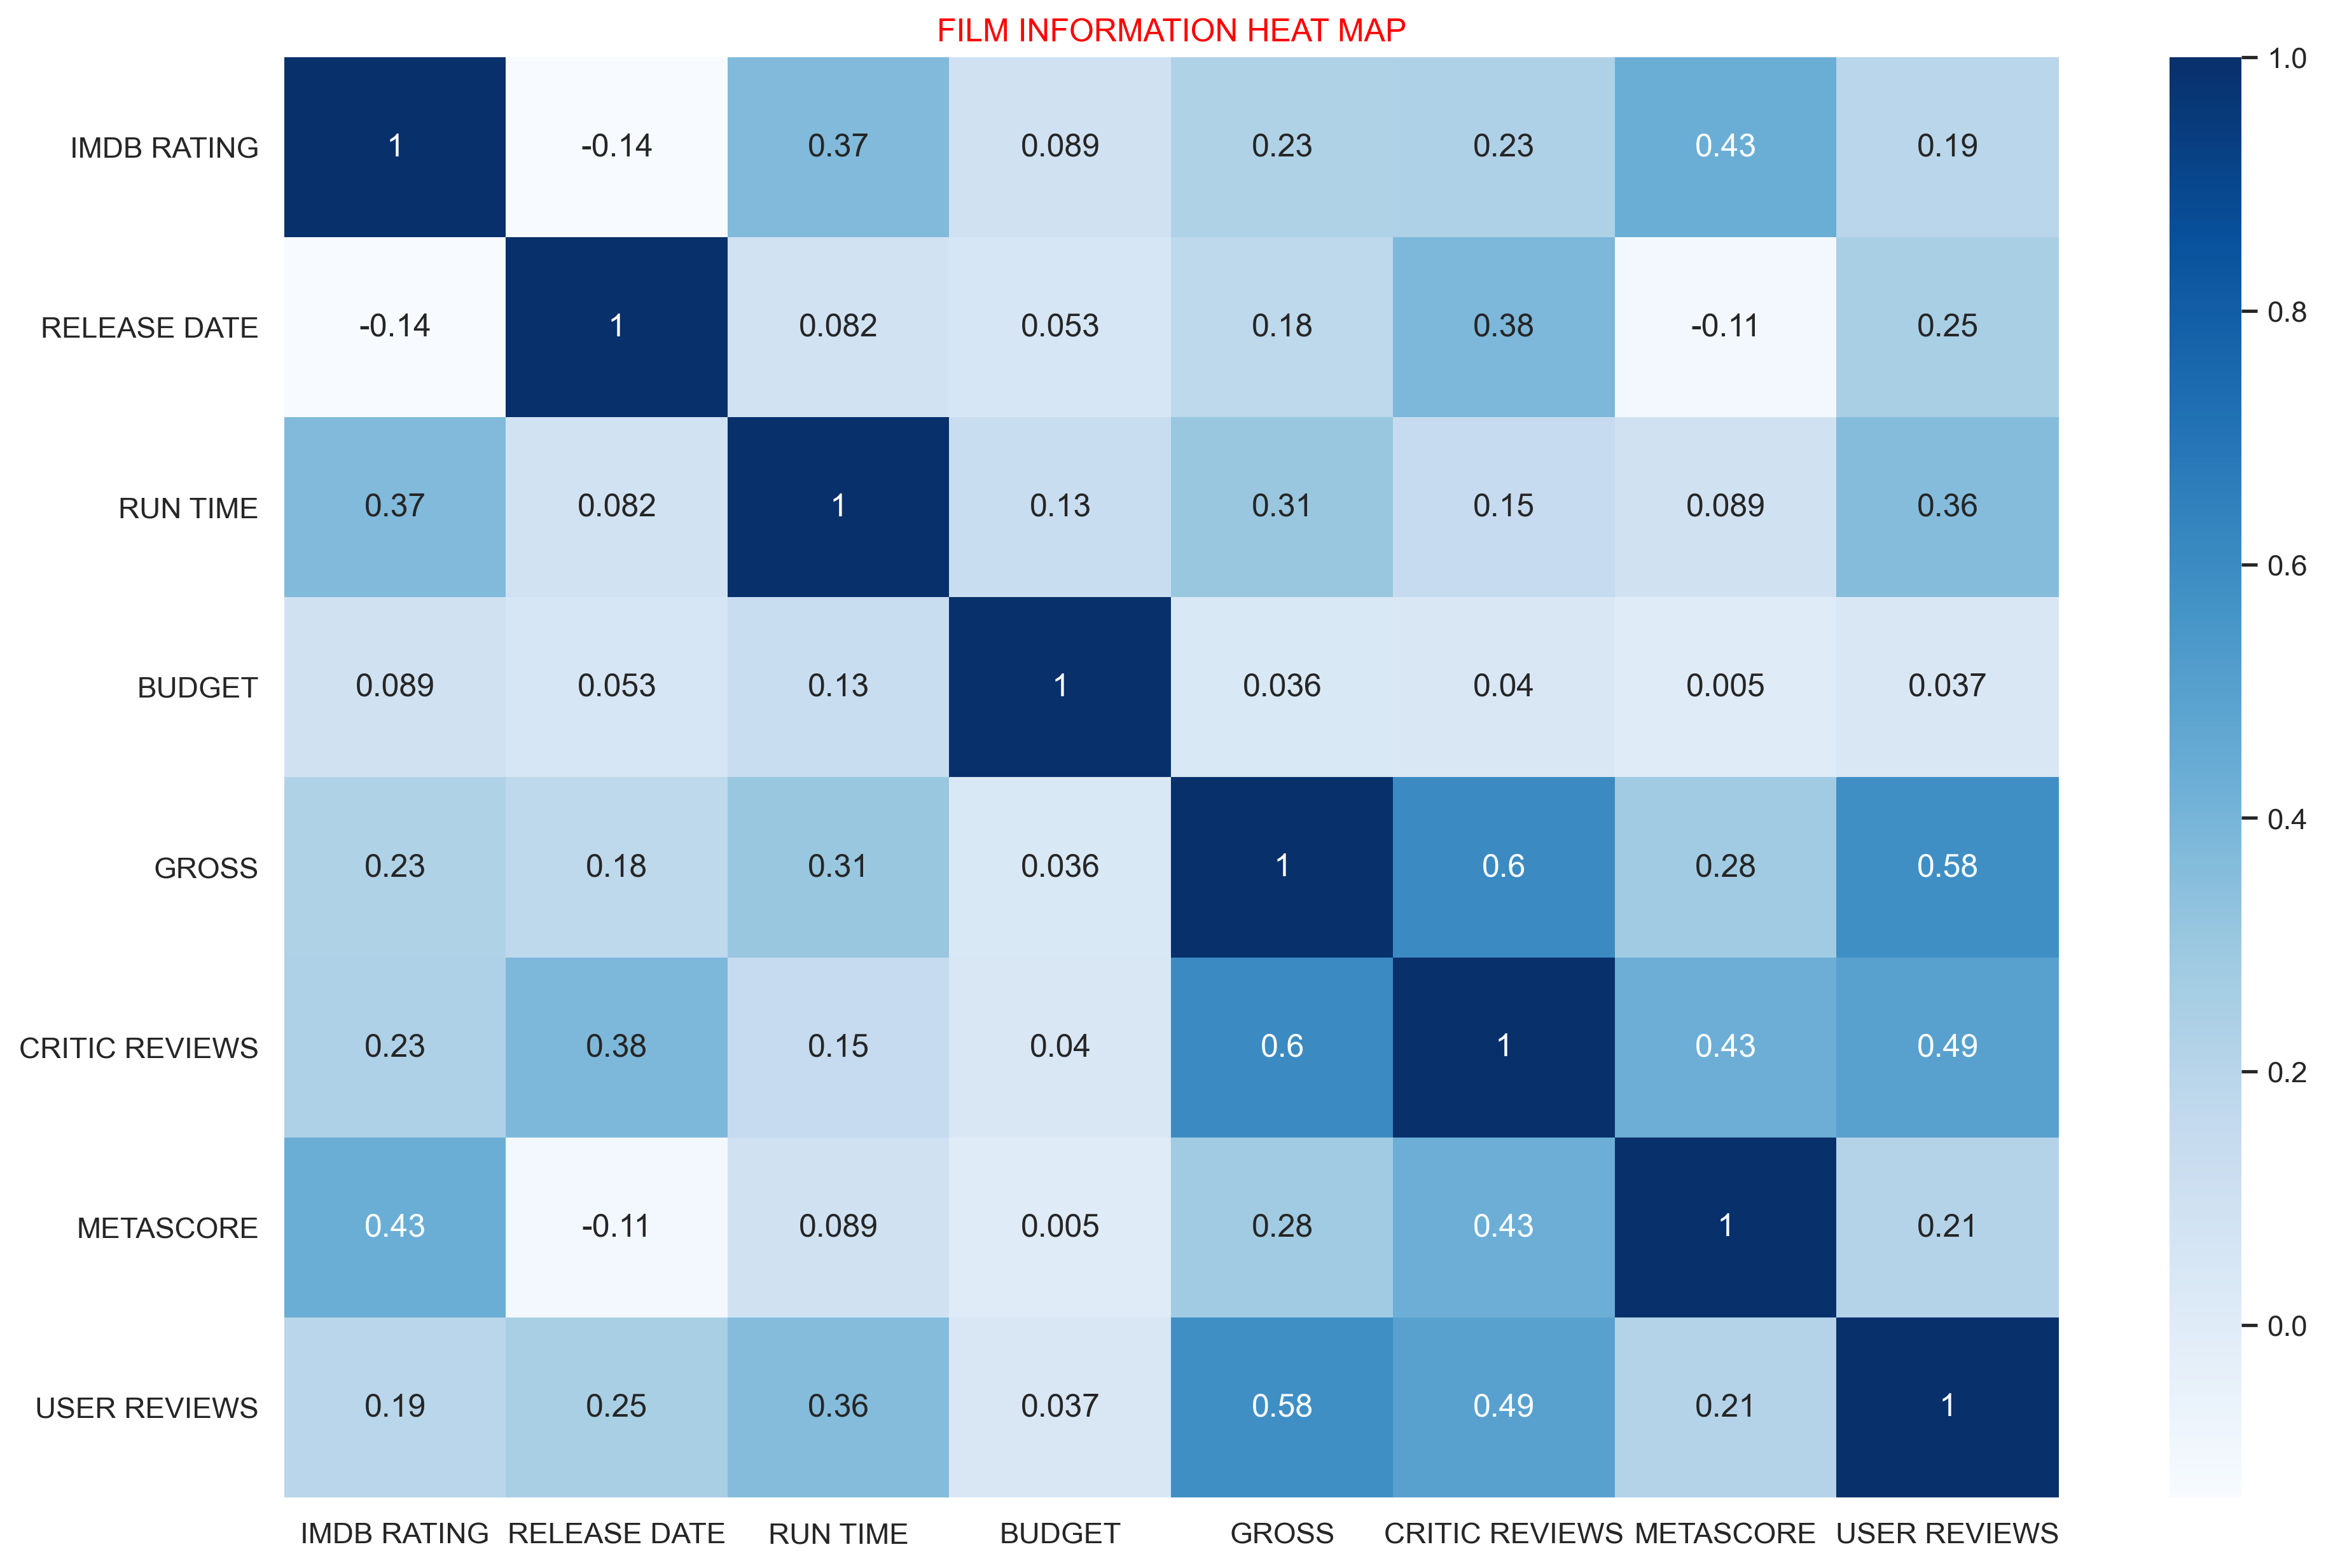

In [75]:
plt.figure(figsize=(15,10),dpi=300)
plt.title("FILM INFORMATION HEAT MAP", c="red")
sns.heatmap(df.corr(), cmap="Blues", annot=True)

Değişkenlerimizin birbirleri arasındaki ilişkilerin ısı haritası.

In [76]:
LR = LinearRegression()
x1 = df.drop(columns=['FILM','IMDB RATING','DIRECTOR'])
y1 = df['IMDB RATING']

In [77]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=.2, random_state=10)

In [78]:
## Eğitme

LR.fit(x_train1,y_train1)
prediction1 = LR.predict(x_test1)

In [79]:
#modelin  r2 scoru - Tahmin yeteneğimiz
LR.score(x_test1, y_test1)

0.3134123294411798

In [80]:
MSE = np.mean((prediction1 - y_test1)**2)
MSE

0.6451281106359668

In [81]:
df

,FILM,IMDB RATING,DIRECTOR,RELEASE DATE,RUN TIME,BUDGET,GROSS,CRITIC REVIEWS,METASCORE,USER REVIEWS
1,K.G.F: Chapter 2,9.6,Prashanth Neel,2022,168.0,8.000000e+08,2.874000e+06,23,0,1100.0
2,The Dark Knight,9.0,Christopher Nolan,2008,152.0,1.850000e+08,1.006102e+09,434,84,8000.0
3,The Lord of the Rings: The Return of the King,9.0,Peter Jackson,2003,201.0,9.400000e+07,1.146436e+09,340,94,4000.0
4,RRR (Rise Roar Revolt),8.9,S.S. Rajamouli,2022,187.0,3.500000e+09,9.959287e+07,33,87,996.0
5,Inception,8.8,Christopher Nolan,2010,148.0,1.600000e+08,8.368481e+08,480,74,4500.0
...,...,...,...,...,...,...,...,...,...,...
1617,Gunday,2.3,Ali Abbas Zafar,2014,152.0,2.000000e+07,1.106181e+07,21,0,896.0
1618,Radhe,2.3,Prabhu Deva,2021,135.0,2.000000e+07,1.900312e+06,22,0,2500.0
1619,Race 3,2.1,Remo D'Souza,2018,160.0,2.000000e+07,2.996969e+07,24,0,472.0
1620,House of the Dead,2.1,Uwe Boll,2003,90.0,1.200000e+07,1.381818e+07,138,15,606.0


# Feature Extraction

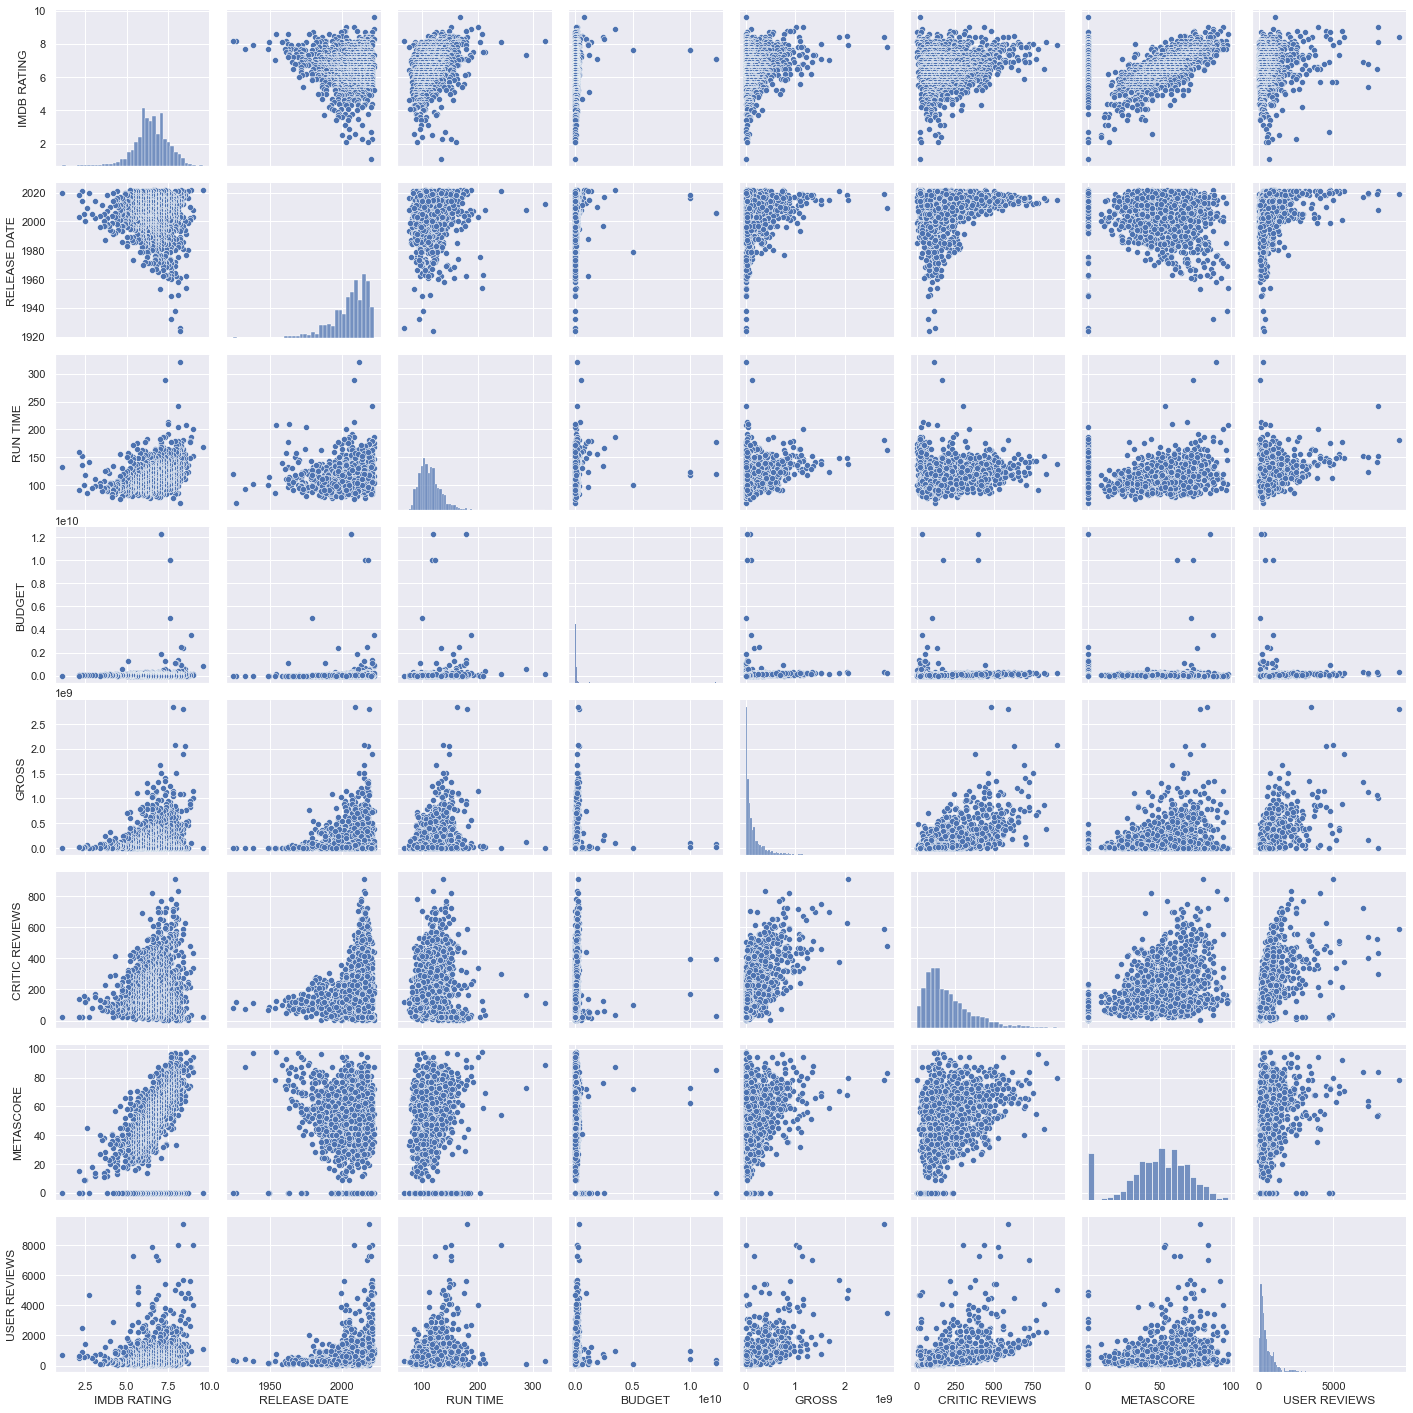

In [82]:
sns.pairplot(df)

In [83]:
df_iliski =df[['IMDB RATING', 'RELEASE DATE', 'RUN TIME', 'BUDGET',
       'GROSS', 'CRITIC REVIEWS', 'METASCORE', 'USER REVIEWS']]

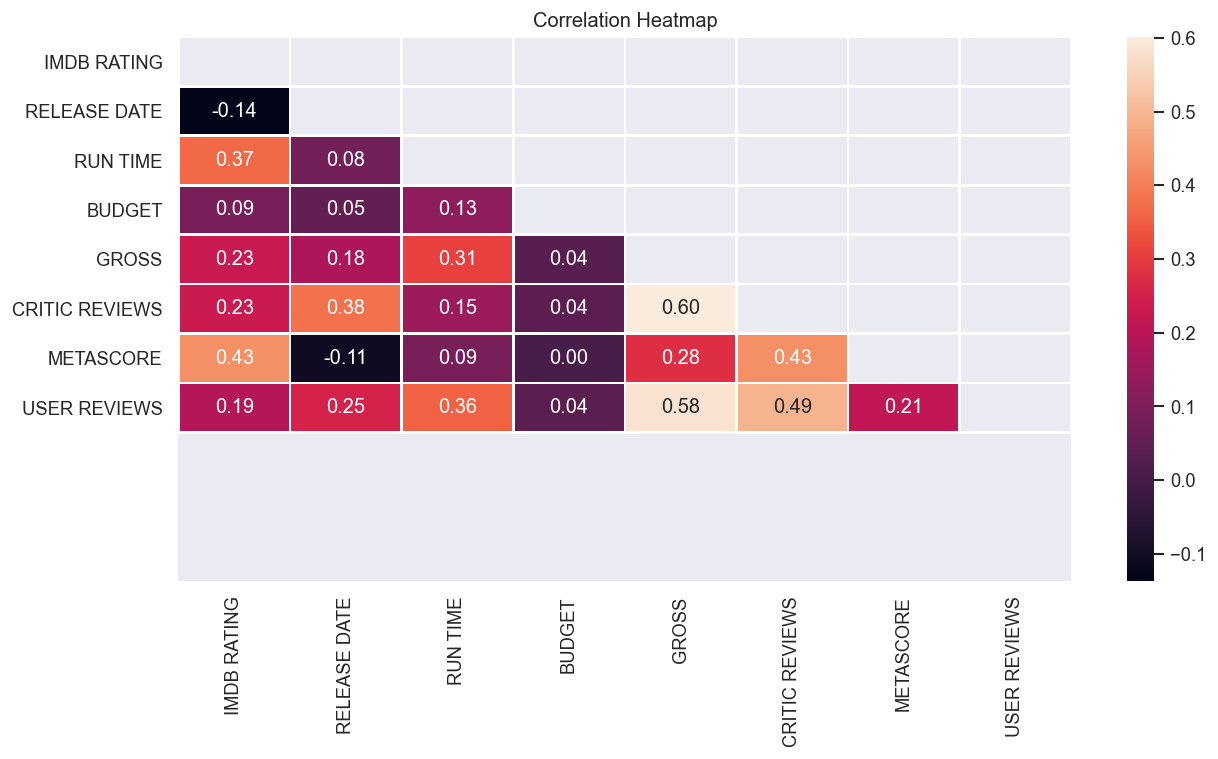

In [84]:
plt.figure(dpi = 120, figsize= (12,6))
mask = np.triu(np.ones_like(df_iliski.corr(),dtype = bool))
ax = sns.heatmap(df_iliski.corr(), mask = mask, fmt = ".2f", 
                 annot=True, lw=1, 
                 linewidths=0.5)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
ax.set_ylim(11, 0)
plt.show()

Metascore IMDB RATING ile ilişkisi kuvvetli olduğu için poly değişken olarak yeni bir kolon oluşturuldu.

In [85]:
df["POLY_METASCORE"] = df['METASCORE']**2

Critic reviews ile gross arasında kuvvetli bir ilişki var gözüküyor.

In [86]:
df["GR_X_REV"] = df['CRITIC REVIEWS']* df['GROSS']

In [87]:
df.head()

,FILM,IMDB RATING,DIRECTOR,RELEASE DATE,RUN TIME,BUDGET,GROSS,CRITIC REVIEWS,METASCORE,USER REVIEWS,POLY_METASCORE,GR_X_REV
1,K.G.F: Chapter 2,9.6,Prashanth Neel,2022,168.0,8.000000e+08,2.874000e+06,23,0,1100.0,0,6.610200e+07
2,The Dark Knight,9.0,Christopher Nolan,2008,152.0,1.850000e+08,1.006102e+09,434,84,8000.0,7056,4.366484e+11
3,The Lord of the Rings: The Return of the King,9.0,Peter Jackson,2003,201.0,9.400000e+07,1.146436e+09,340,94,4000.0,8836,3.897883e+11
4,RRR (Rise Roar Revolt),8.9,S.S. Rajamouli,2022,187.0,3.500000e+09,9.959287e+07,33,87,996.0,7569,3.286565e+09
5,Inception,8.8,Christopher Nolan,2010,148.0,1.600000e+08,8.368481e+08,480,74,4500.0,5476,4.016871e+11


## LINEAR REGRESSION

In [88]:
LR = LinearRegression()

In [89]:
x = df.drop(columns=['FILM','IMDB RATING','DIRECTOR'])

In [91]:
y = df['IMDB RATING']

In [92]:
x

,RELEASE DATE,RUN TIME,BUDGET,GROSS,CRITIC REVIEWS,METASCORE,USER REVIEWS,POLY_METASCORE,GR_X_REV
1,2022,168.0,8.000000e+08,2.874000e+06,23,0,1100.0,0,6.610200e+07
2,2008,152.0,1.850000e+08,1.006102e+09,434,84,8000.0,7056,4.366484e+11
3,2003,201.0,9.400000e+07,1.146436e+09,340,94,4000.0,8836,3.897883e+11
4,2022,187.0,3.500000e+09,9.959287e+07,33,87,996.0,7569,3.286565e+09
5,2010,148.0,1.600000e+08,8.368481e+08,480,74,4500.0,5476,4.016871e+11
...,...,...,...,...,...,...,...,...,...
1617,2014,152.0,2.000000e+07,1.106181e+07,21,0,896.0,0,2.322981e+08
1618,2021,135.0,2.000000e+07,1.900312e+06,22,0,2500.0,0,4.180686e+07
1619,2018,160.0,2.000000e+07,2.996969e+07,24,0,472.0,0,7.192726e+08
1620,2003,90.0,1.200000e+07,1.381818e+07,138,15,606.0,225,1.906909e+09


In [93]:
y

1       9.6
2       9.0
3       9.0
4       8.9
5       8.8
       ... 
1617    2.3
1618    2.3
1619    2.1
1620    2.1
1621    1.1
Name: IMDB RATING, Length: 1621, dtype: float64

In [94]:
## Seti Bölme
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=10)

In [95]:
## Eğitme

LR.fit(x_train,y_train)
prediction = LR.predict(x_test)

In [96]:
#modelin  r2 scoru - Tahmin yeteneğimiz
LR.score(x_test, y_test)

0.4384313460647544

In [97]:
MSE = np.mean((prediction - y_test)**2)
MSE

0.5276583606733889

10 katlamalı linear regressionda alınan başarı ortalaması

In [98]:
from sklearn.model_selection import cross_val_score
basari = cross_val_score(estimator = LR, X=x_train, y=y_train , cv = 10)

In [99]:
basari

array([0.46043857, 0.46670752, 0.44538434, 0.33395492, 0.31067101,
       0.36723055, 0.43984257, 0.46294567, 0.43819133, 0.38512328])

In [100]:
basari.mean()

0.4110489759254879

# RIDGE REGRESSION

In [101]:
##training the model
RidgeReg = Ridge(alpha=0.05, normalize=True)
RidgeReg.fit(x_train,y_train)
RidgePredict = RidgeReg.predict(x_test)


In [102]:
#modelin  r2 scoru - Tahmin yeteneğimiz
RidgeReg.score(x_test, y_test)

0.41507560250696174

In [103]:
MSE = np.mean((RidgePredict - y_test)**2)
MSE

0.5496037689002411

10 katlamalı Ridge regressionda alınan başarı ortalaması

In [104]:
basariRidge = cross_val_score(estimator = RidgeReg, X=x_train, y=y_train , cv = 5)

In [105]:
basariRidge

array([0.4537991 , 0.35553811, 0.29470504, 0.45574729, 0.40377548])

In [106]:
basariRidge.mean()

0.3927130056178288

# LASSO REGRESSION

In [108]:
LassoReg = Lasso(alpha=5, normalize=True)

LassoReg.fit(x_train,y_train)

LassoPredict = LassoReg.predict(x_test)

In [109]:
#modelin  r2 scoru - Tahmin yeteneğimiz
LassoReg.score(x_test, y_test)

-0.0001179462875677828

In [110]:
MSE = np.mean((LassoPredict - y_test)**2)
MSE

0.9397258773617122

## Sonuç

Başarısı en yüksek olan Linear Regression modeli seçilebilir. 